In [1]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
import glob
import itertools
import time

from moviepy.editor import VideoFileClip
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

%matplotlib inline

## Data Summary

In [2]:
vehicle_imgs = glob.glob('Data/vehicles/**/*.png')
other_imgs = glob.glob('Data/non_vehicles/**/*.png')

print('Number of vehicle images available: ', len(vehicle_imgs))
print('Number of non-vehicle images available: ', len(other_imgs))

Number of vehicle images available:  8792
Number of non-vehicle images available:  8968


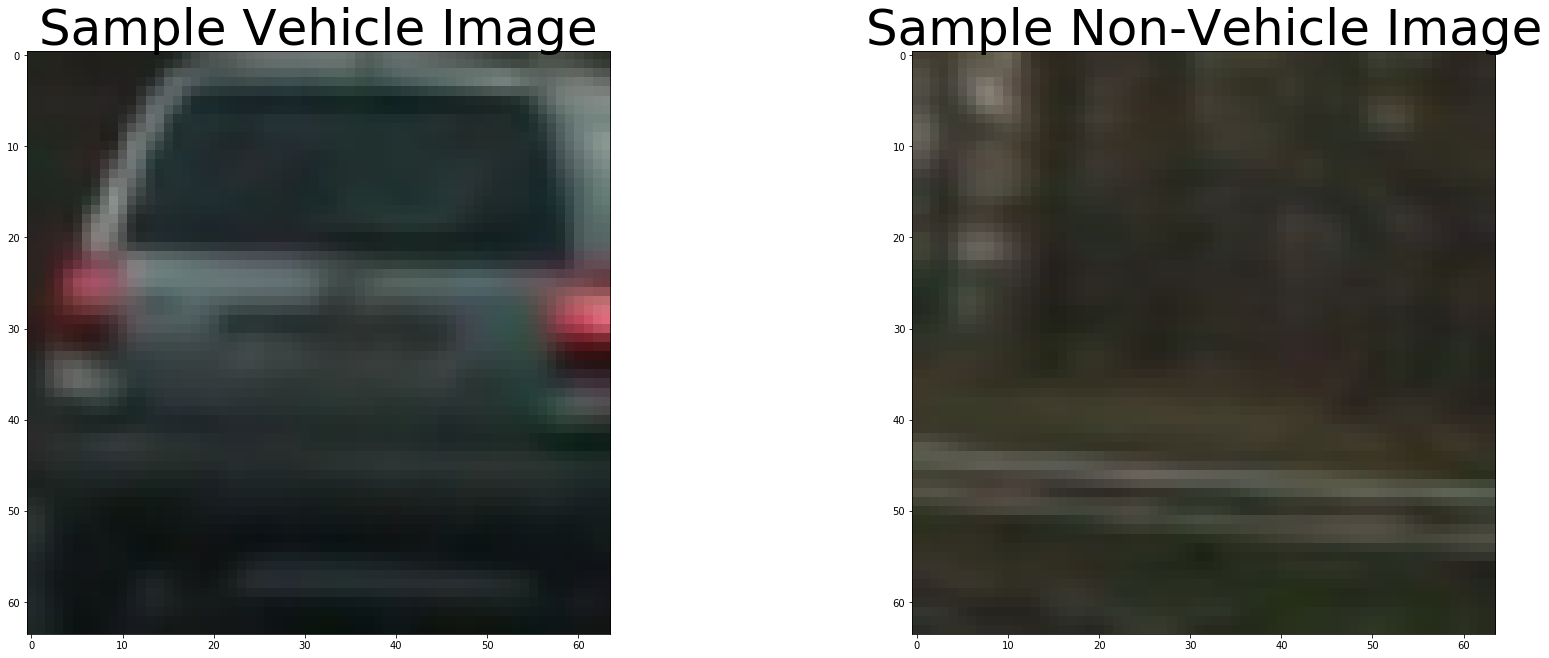

In [7]:
#this function plots two images side by side
def plotImgs(img1, title1, img2, title2):
    f, (ax1, ax2) = plt.subplots(1,2,figsize=(24,9))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(img2)
    ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0,right=1,top=0.9,bottom=0)
    plt.show()
    
img1 = mpimg.imread(vehicle_imgs[0])
img2 = mpimg.imread(other_imgs[0])

plotImgs(img1, 'Sample Vehicle Image', img2,'Sample Non-Vehicle Image')

## Image to HOG (feature extraction)

In [16]:
def hog_features(img, orient_, pix_per_cell, cell_per_block, visual=False, feature_vec=True):
    # if visual is true return features and hog_image
    if visual == True:
        features, hog_image = hog(img, orientations=orient_,pixels_per_cell=(pix_per_cell, pix_per_cell),cells_per_block=(cell_per_block, cell_per_block),transform_sqrt=False, visualise=visual, feature_vector=feature_vec)
        return features, hog_image
    # else return just features
    else:      
        features = hog(img, orientations=orient_, pixels_per_cell=(pix_per_cell, pix_per_cell),cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, visualise=visual, feature_vector=feature_vec)
        return features

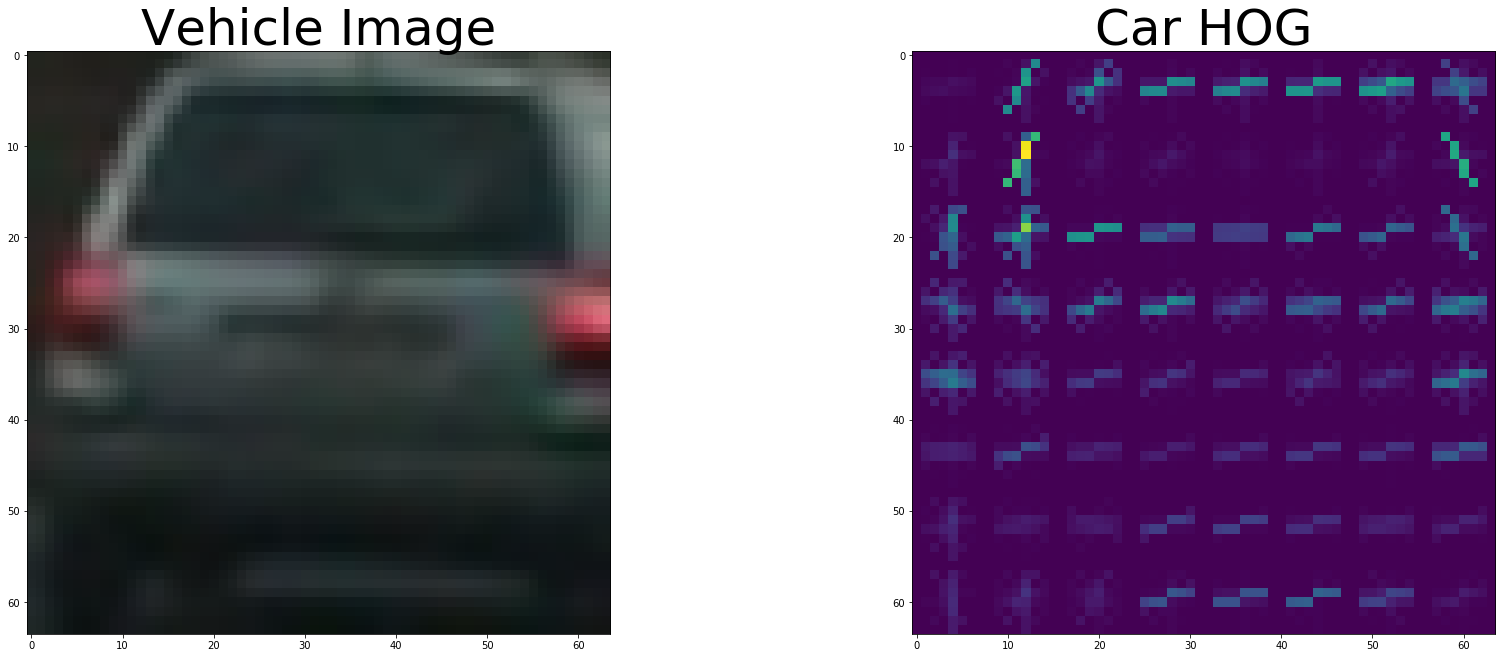

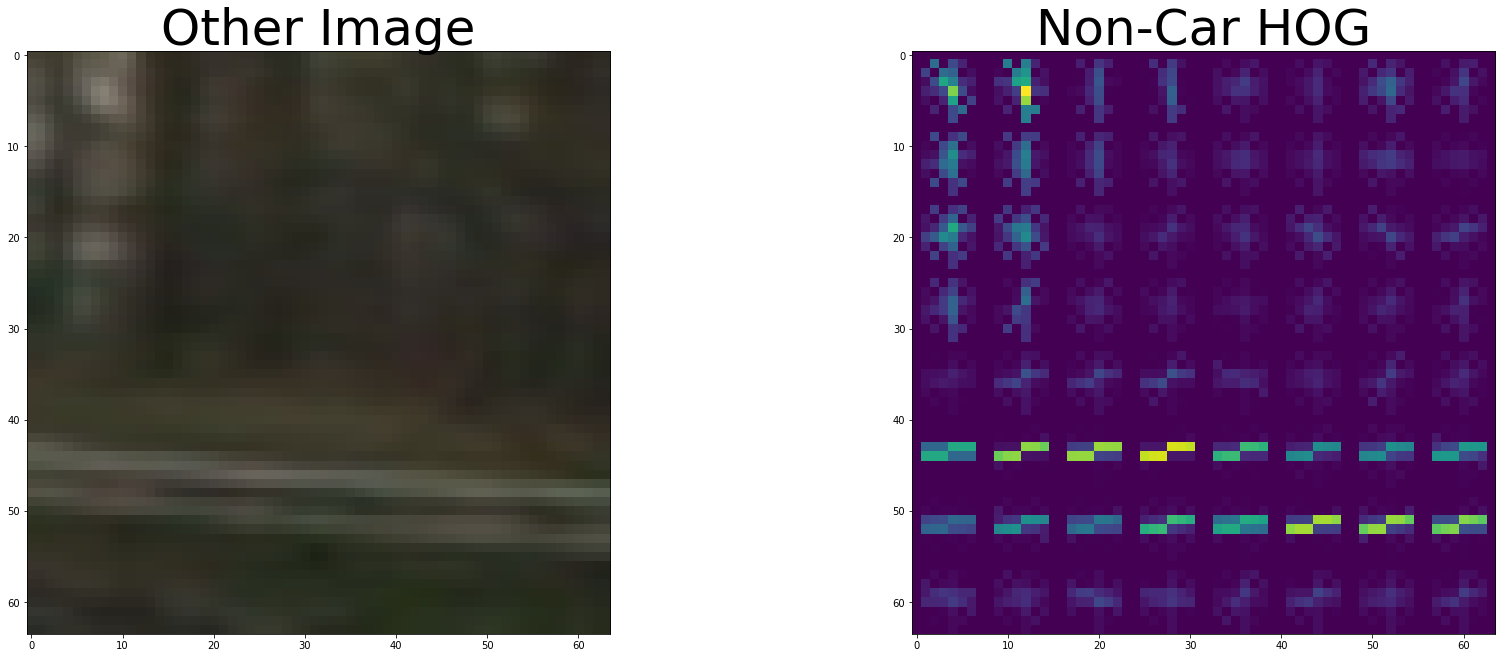

In [19]:
car_img = mpimg.imread(vehicle_imgs[0])
_, car_hog1 = hog_features(car_img[:,:,2], 9, 8, 8, visual=True, feature_vec=True)
noncar_img = mpimg.imread(other_imgs[0])
_, noncar_hog1 = hog_features(noncar_img[:,:,2], 9, 8, 8, visual=True, feature_vec=True)

plotImgs(car_img, 'Vehicle Image', car_hog1,'Car HOG')
plotImgs(noncar_img, 'Other Image', noncar_hog1,'Non-Car HOG')

In [24]:
#This function creates a list of features from a list of images 
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # imgs is a glob object
    # list to append feature vectors
    features = []
    # iterate through the list of images
    for file in imgs:
        # read the image
        image = mpimg.imread(file)
        # apply color conversion
        if cspace != 'RGB':
            feature_image = cv2.cvtColor(image, getattr(cv2,'COLOR_RGB2'+cspace))
        else: 
            feature_image = np.copy(image)      

        # call hog_features() with visual=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features_list = []
            for channel in range(feature_image.shape[2]):
                hog_features_list.append(hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    visual=False, feature_vec=True))
            hog_features_list = np.ravel(hog_features_list)        
        else:
            hog_features_list = hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, visual=False, feature_vec=True)
        # append the new feature vector to the features list
        features.append(hog_features_list)
    # return list of feature vectors
    return features

### Creating Training and Testing Datasets

In [25]:
# parameters
colorspace = 'YUV' # can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # can be 0, 1, 2, or "ALL"

car_features = extract_features(vehicle_imgs, cspace=colorspace, orient=orient,pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,hog_channel=hog_channel)
notcar_features = extract_features(other_imgs, cspace=colorspace, orient=orient,pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,hog_channel=hog_channel)
# create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# create y vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Parameters used:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Parameters used: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


## Training Support Vector Classifier (Linear)

In [126]:
# using a linear SVC 
svc = LinearSVC()
# training
t1 = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print('Training time is: ',round(t2-t1, 2))

# test accuracy
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4)*100,' %')

Training time is:  0.96
Test Accuracy of SVC =  97.97  %


## Finding Cars and Drawing Boxes

In [30]:
# this function draws boxes when diagonal points are given
def draw_boxes(img, bboxes, color=(0, 255, 0), thick=6):
    # bboxes is list of rectangles
    # copy of the image
    imcopy = np.copy(img)
    
    for bbox in bboxes:
        # points given are diagonally opposite points
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    
    return imcopy

In [35]:
# this function finds the cars in a image
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    # list to which found rectangles are added
    rectangles = []
    
    # normalizing
    img = img.astype(np.float32)/255
    
    # strip of the image to search for
    img_tosearch = img[ystart:ystop,:,:]

    # color conversion if other than 'RGB'
    if cspace != 'RGB':
        ctrans_tosearch = cv2.cvtColor(img_tosearch, getattr(cv2, 'COLOR_RGB2'+cspace))
    else:
        ctrans_tosearch = np.copy(image)   
    
    # rescale image if necessary
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0] #r
        ch2 = ctrans_tosearch[:,:,1] #g
        ch3 = ctrans_tosearch[:,:,2] #b
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # blocks and steps
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # individual channel HOG features for the entire image
    hog1 = hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # extracting HOG for patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features1 = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features1 = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            test_prediction = svc.predict(hog_features1)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

###### Classifier performance

In [ ]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

rectangles_ = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None)

In [ ]:
plt.clf()
test_img_rects = draw_boxes(test_img, rectangles_)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

###### Search area of the image

In [175]:
# this function search the image more thoroughly  
def cmplx_find_car(img, all_recs = False):
    #parameters
    colorspace = 'YUV' 
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL'

    ystart_l = [300,350,400,413,434,455, 489]
    scale_l = [1, 1.5,2]

    car_rec = []
    for ystart, scale in itertools.product(ystart_l, scale_l):
        ystop = ystart + int(scale*64)
        car_rec.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None,show_all_rectangles=all_recs))

    car_rec = list(itertools.chain(*car_rec))
    return car_rec

###### Entire Search Area

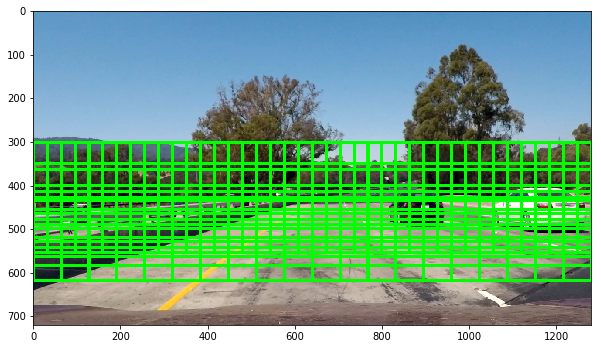

In [168]:
plt.clf()
all_boxes = cmplx_find_car(test, all_recs=True)
test_with_rects = draw_boxes(test, all_boxes)
plt.figure(figsize=(10,10))
plt.imshow(test_with_rects)

## Heatmap

In [67]:
# think of heatmap as number of times we find the same car
def heatmap_fn(heatmap, bboxes):
    # 
    for box in bboxes:
        '''
        add += 1 for all pixels inside each bbox and
        assuming each "box" takes the form ((x1, y1), (x2, y2))
        '''
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap

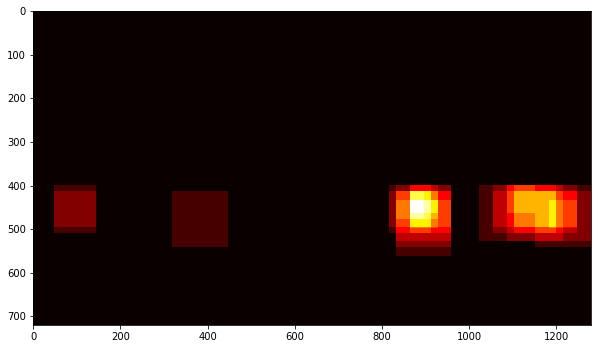

In [68]:
sample_heatmap = heatmap_fn(np.zeros_like(test[:,:,0]), r_boxes)

plt.clf()
plt.figure(figsize=(10,10))
plt.imshow(sample_heatmap, cmap='hot')

In [178]:
# eliminates false positives
def heat_map_threshold(heatmap, threshold):
    heatmap[heatmap < threshold] = 0
    return heatmap

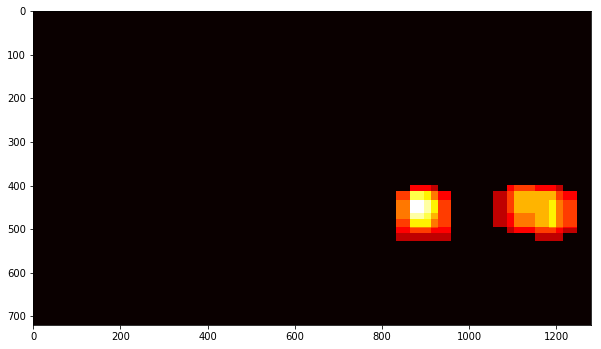

In [72]:
sample_heatmap_threshold = heat_map_threshold(sample_heatmap, 2)

plt.clf()
plt.figure(figsize=(10,10))
plt.imshow(sample_heatmap_threshold, cmap='hot')

2 cars found


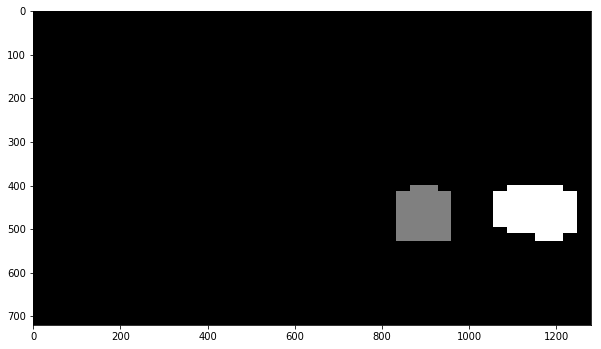

In [73]:
labels = label(sample_heatmap_threshold)

plt.clr()
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

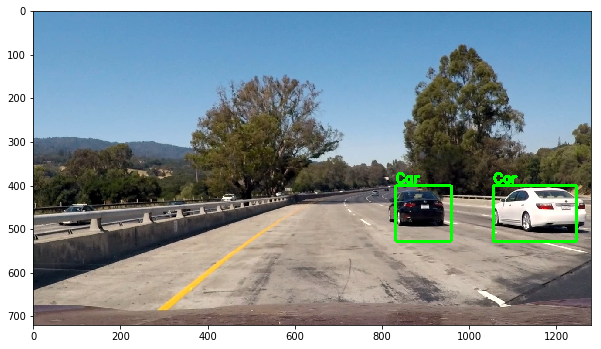

In [169]:
# this function draws the final box
def draw_final_box(img, labels):
    # iterate through all detected cars aka labels
    rects = []
    # iterate through all detected cars aka labels
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
        cv2.putText(img, 'Car', (bbox[0][0],bbox[0][1]-7), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),6)
    # Return the image and final rectangles
    return img, rects

# draw bounding boxes on a copy of the image
draw_img, rect = draw_final_box(np.copy(test), labels)

plt.clf()
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

In [183]:
# pipeling
def pipeline(img):
    rectangles = cmplx_find_car(img, all_recs = False)
    heatmap_img = heatmap_fn(np.zeros_like(img[:,:,0]), rectangles)
    heatmap_img = heat_map_threshold(heatmap_img, 4)
    labels = label(heatmap_img)
    draw_img, rect = draw_final_box(img, labels)
    return draw_img
    

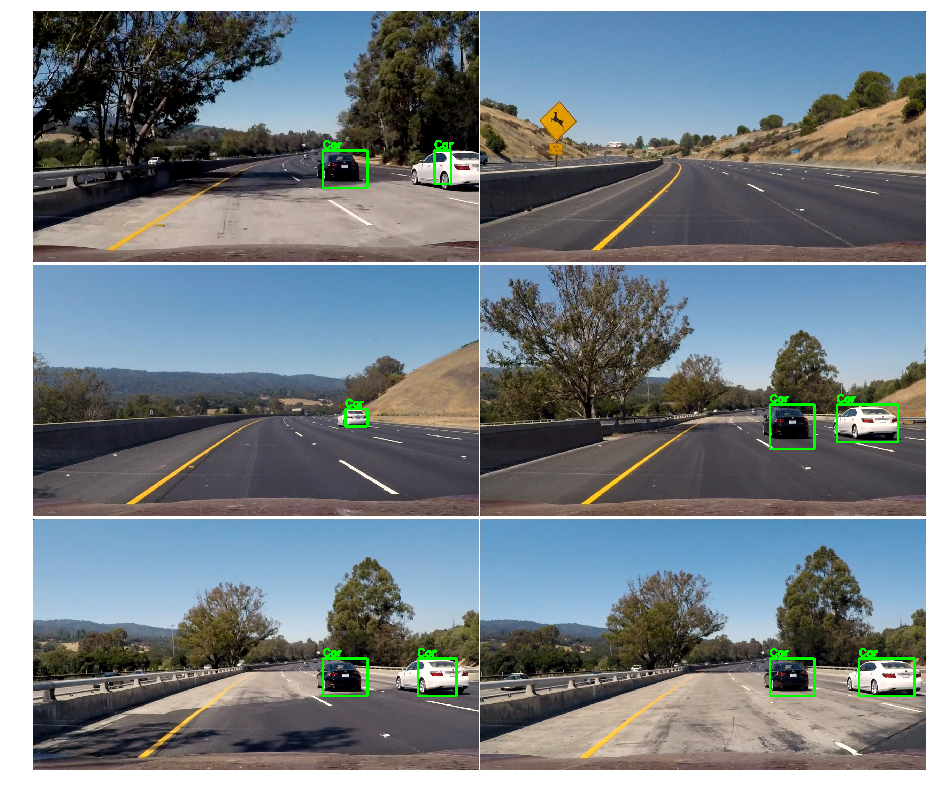

In [184]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(pipeline(mpimg.imread(im)))
    axs[i].axis('off')

In [185]:
test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(pipeline)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [16:08<00:00,  1.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 18min 9s, sys: 3.52 s, total: 18min 13s
Wall time: 16min 9s
